In [62]:
import torch, cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np

class SAM2ImageProcessor:
    def __init__(self, checkpoint, model_cfg, device="cpu"):
        self.predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint, device=device))

    def process_image(self, image_data, point_coords, point_labels):
        self.predictor.set_image(image_data)
        masks, _, _ = self.predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=False,
        )
        mask_array = masks[0]
        uint8_array = (mask_array * 255).astype(np.uint8)
        return uint8_array
    
    def get_smooth_image(self, input_mat, ratio = 100, area_ratio = 10):
        height, width = input_mat.shape
        kernel_size = (int(width/ratio), int(height/ratio))
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
        filled_image = cv2.morphologyEx(input_mat, cv2.MORPH_CLOSE, kernel)

        # 去除面积小于500的连通域
        invert_image = cv2.bitwise_not(filled_image)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(invert_image, connectivity=8)

        min_size = height * width * area_ratio / ratio / ratio
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] < min_size:
                invert_image[labels == i] = 0
                
        invert_image = cv2.bitwise_not(invert_image)
        # 使用Canny算子获取边缘
        edges = cv2.Canny(invert_image, 100, 200)
        return edges

    def detect(self, image_data, point_coords, point_labels, ratio = 100, area_ratio = 10):
        mask_mat = self.process_image(image_data, point_coords, point_labels)
        filled_mat = self.get_smooth_image(mask_mat, ratio, area_ratio)
        return filled_mat



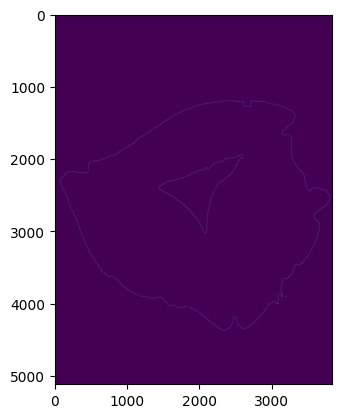

In [63]:
import matplotlib.pyplot as plt

checkpoint = "D:/python/sam2_label/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg  = "D:/python/sam2_label/sam2/configs/sam2.1/sam2.1_hiera_b+.yaml"
image_path = 'E:/dataset/鲫鱼/200_00fb306e03d311f5c33830ab89f65c5b.jpg'
image_data = Image.open(image_path)
numpy_image = np.array(image_data)

processor = SAM2ImageProcessor(checkpoint, model_cfg)

contours_pts = [[1964, 1721],[1351, 3084],[2800, 2660],[1940, 2470]]
labels = [ 1,  1,  1,  -1]

contours = processor.detect(image_data, point_coords=contours_pts, point_labels=labels)


plt.imshow(contours)

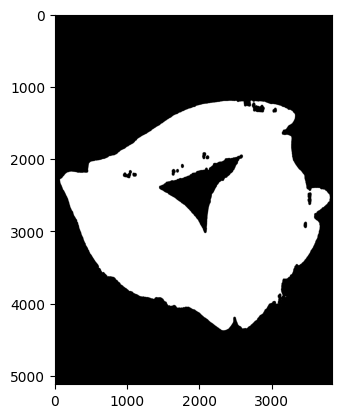

In [41]:
aa = processor.get_smooth_image(contours)
plt.imshow(aa, cmap='gray')

11971414
15860
3230
4074
407320
2181
1897
3863
1619
7975
2811
8221
3581


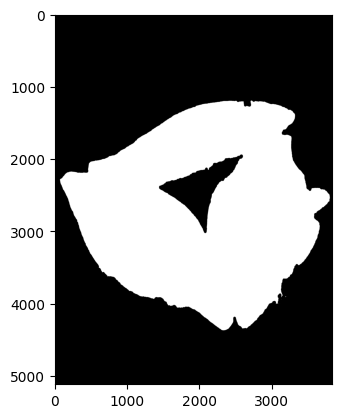

In [49]:
# 使用形态学操作填充孔洞
uint8_array = (contours * 255).astype(np.uint8)
height, width = contours.shape
ratio = 100
# 将kernel大小转换为整数
kernel_size = (int(width/ratio), int(height/ratio))
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
filled_image = cv2.morphologyEx(uint8_array, cv2.MORPH_CLOSE, kernel)

# 去除面积小于500的连通域
invert_image = cv2.bitwise_not(filled_image)

# 确保反转后的图像为8位无符号整型
if invert_image.dtype != np.uint8:
    invert_image = invert_image.astype(np.uint8)

num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(invert_image, connectivity=8)

min_size = height * width * 10 / ratio / ratio
for i in range(1, num_labels):
    print(stats[i, cv2.CC_STAT_AREA])
    if stats[i, cv2.CC_STAT_AREA] < min_size:
        invert_image[labels == i] = 0
        
invert_image = cv2.bitwise_not(invert_image)

# 显示带边缘的图像
plt.imshow(invert_image, cmap='gray')